0.005633802816901409
142
0      0.000000
1      0.056602
2      0.086261
3      0.095236
4      0.081003
         ...   
137    0.079051
138    0.075751
139    0.076137
140    0.041663
141    0.036798
Length: 142, dtype: float64
47
139
-0.10440613026819927


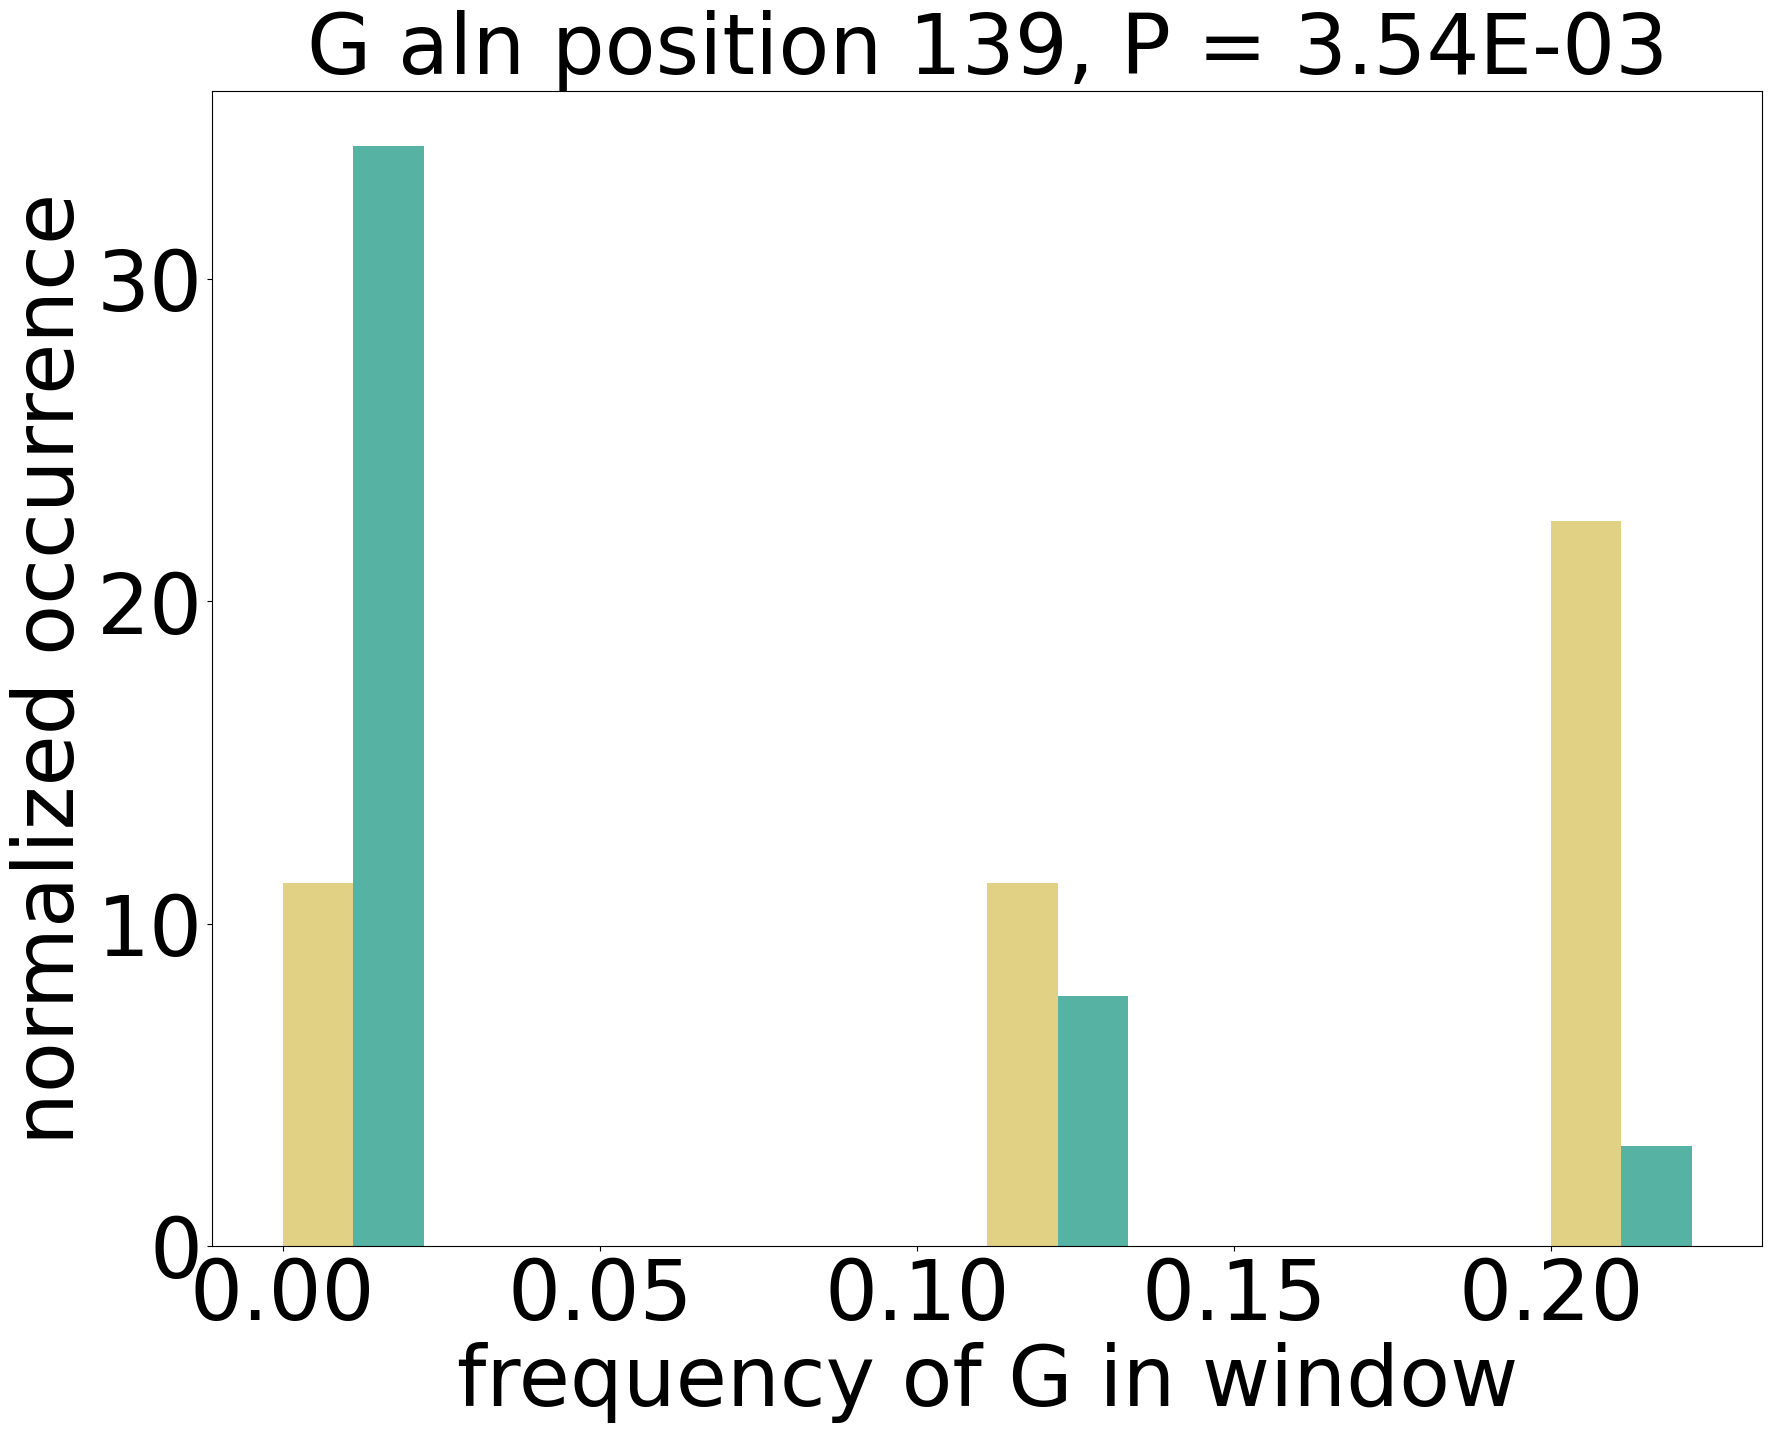

48
142
-0.10440613026819927


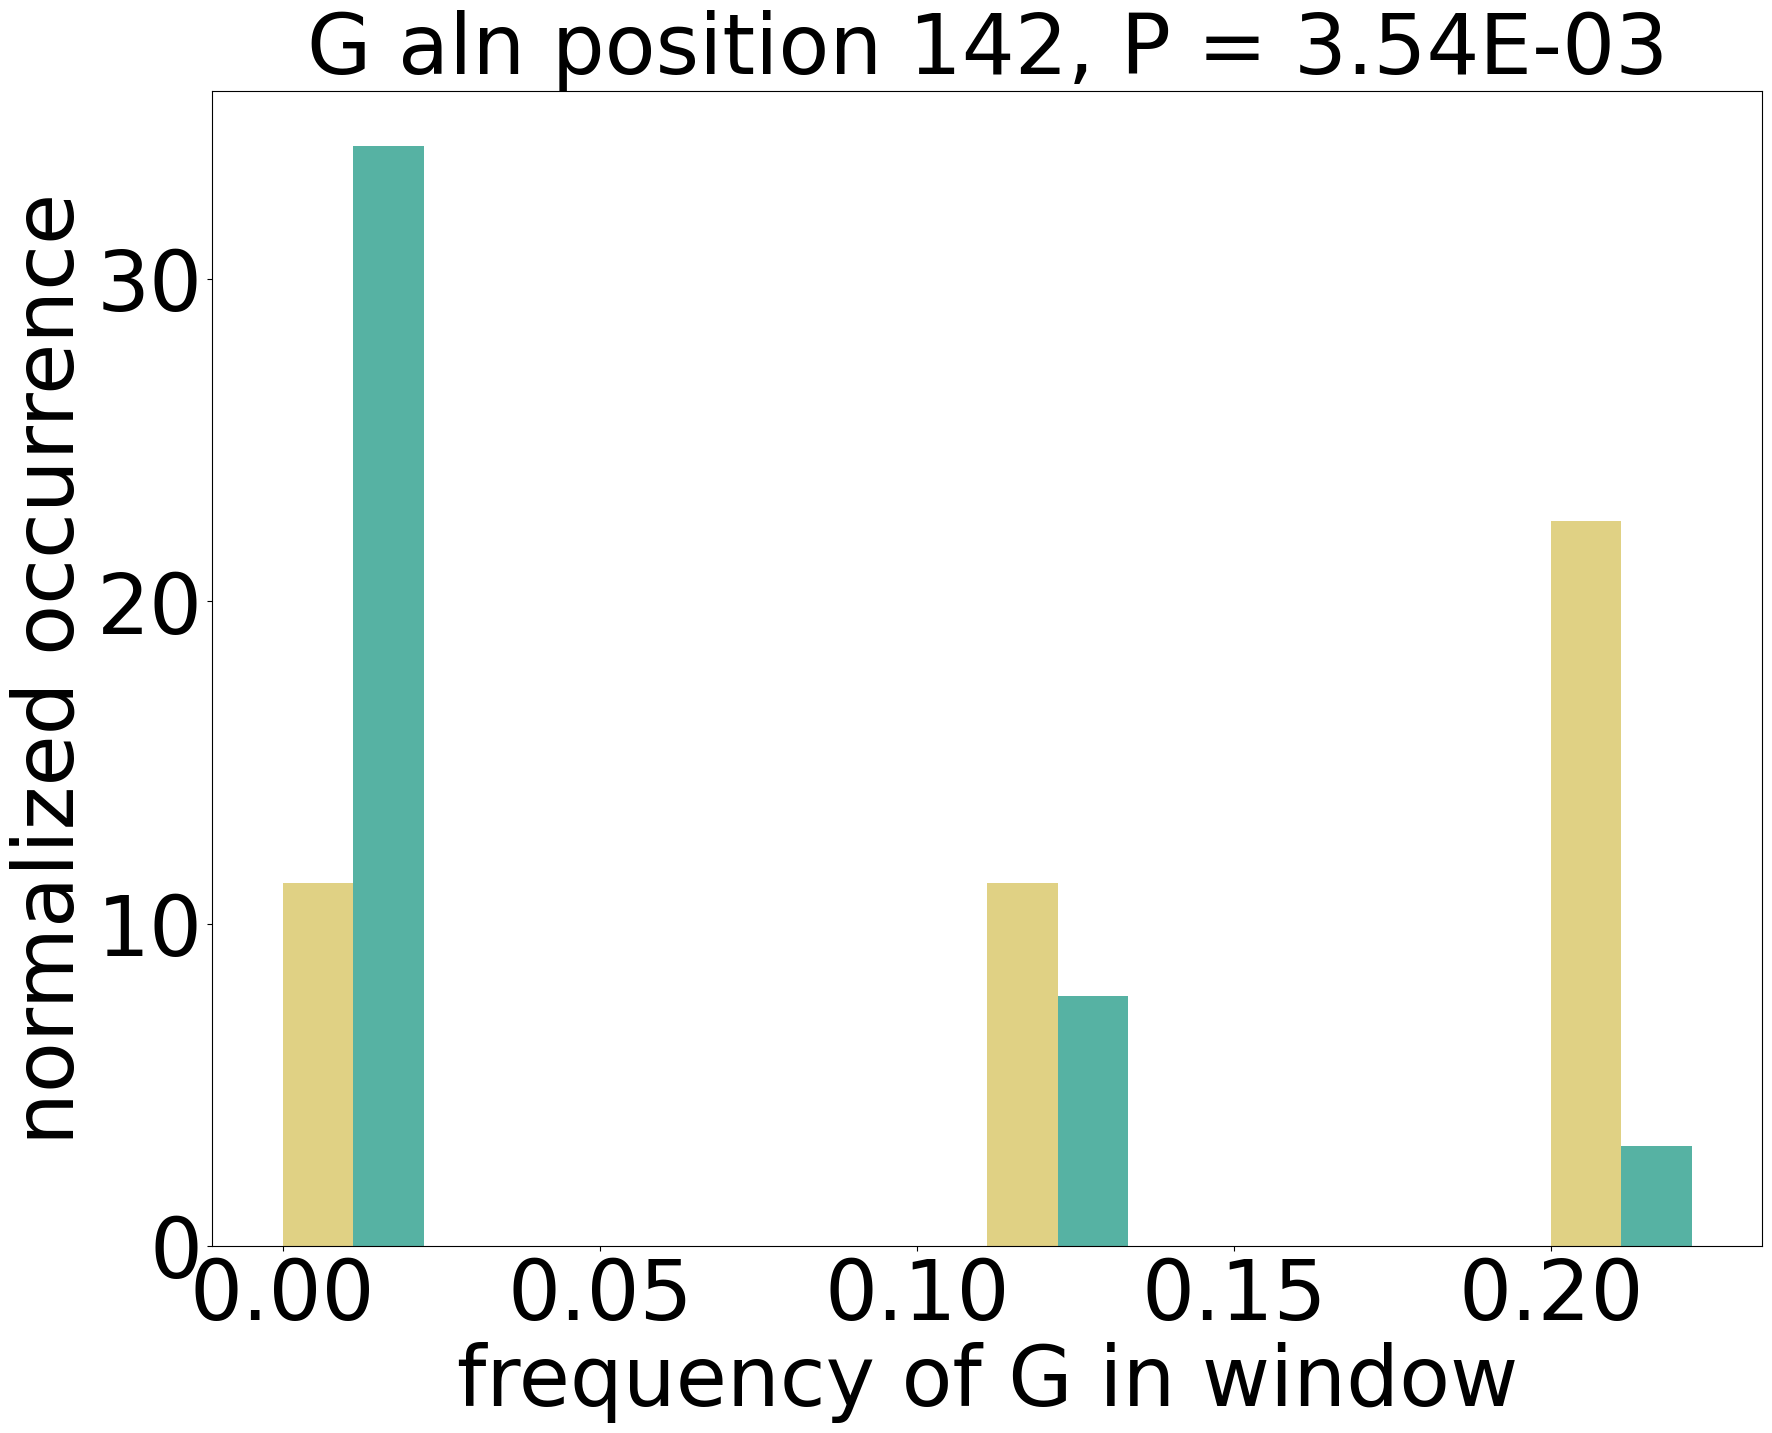

0.005633802816901409
142
0      0.033838
1      0.057599
2      0.057599
3      0.041971
4      0.000000
         ...   
137    0.036798
138    0.045696
139    0.058820
140    0.053476
141    0.046105
Length: 142, dtype: float64
47
139
0.05427841634738188


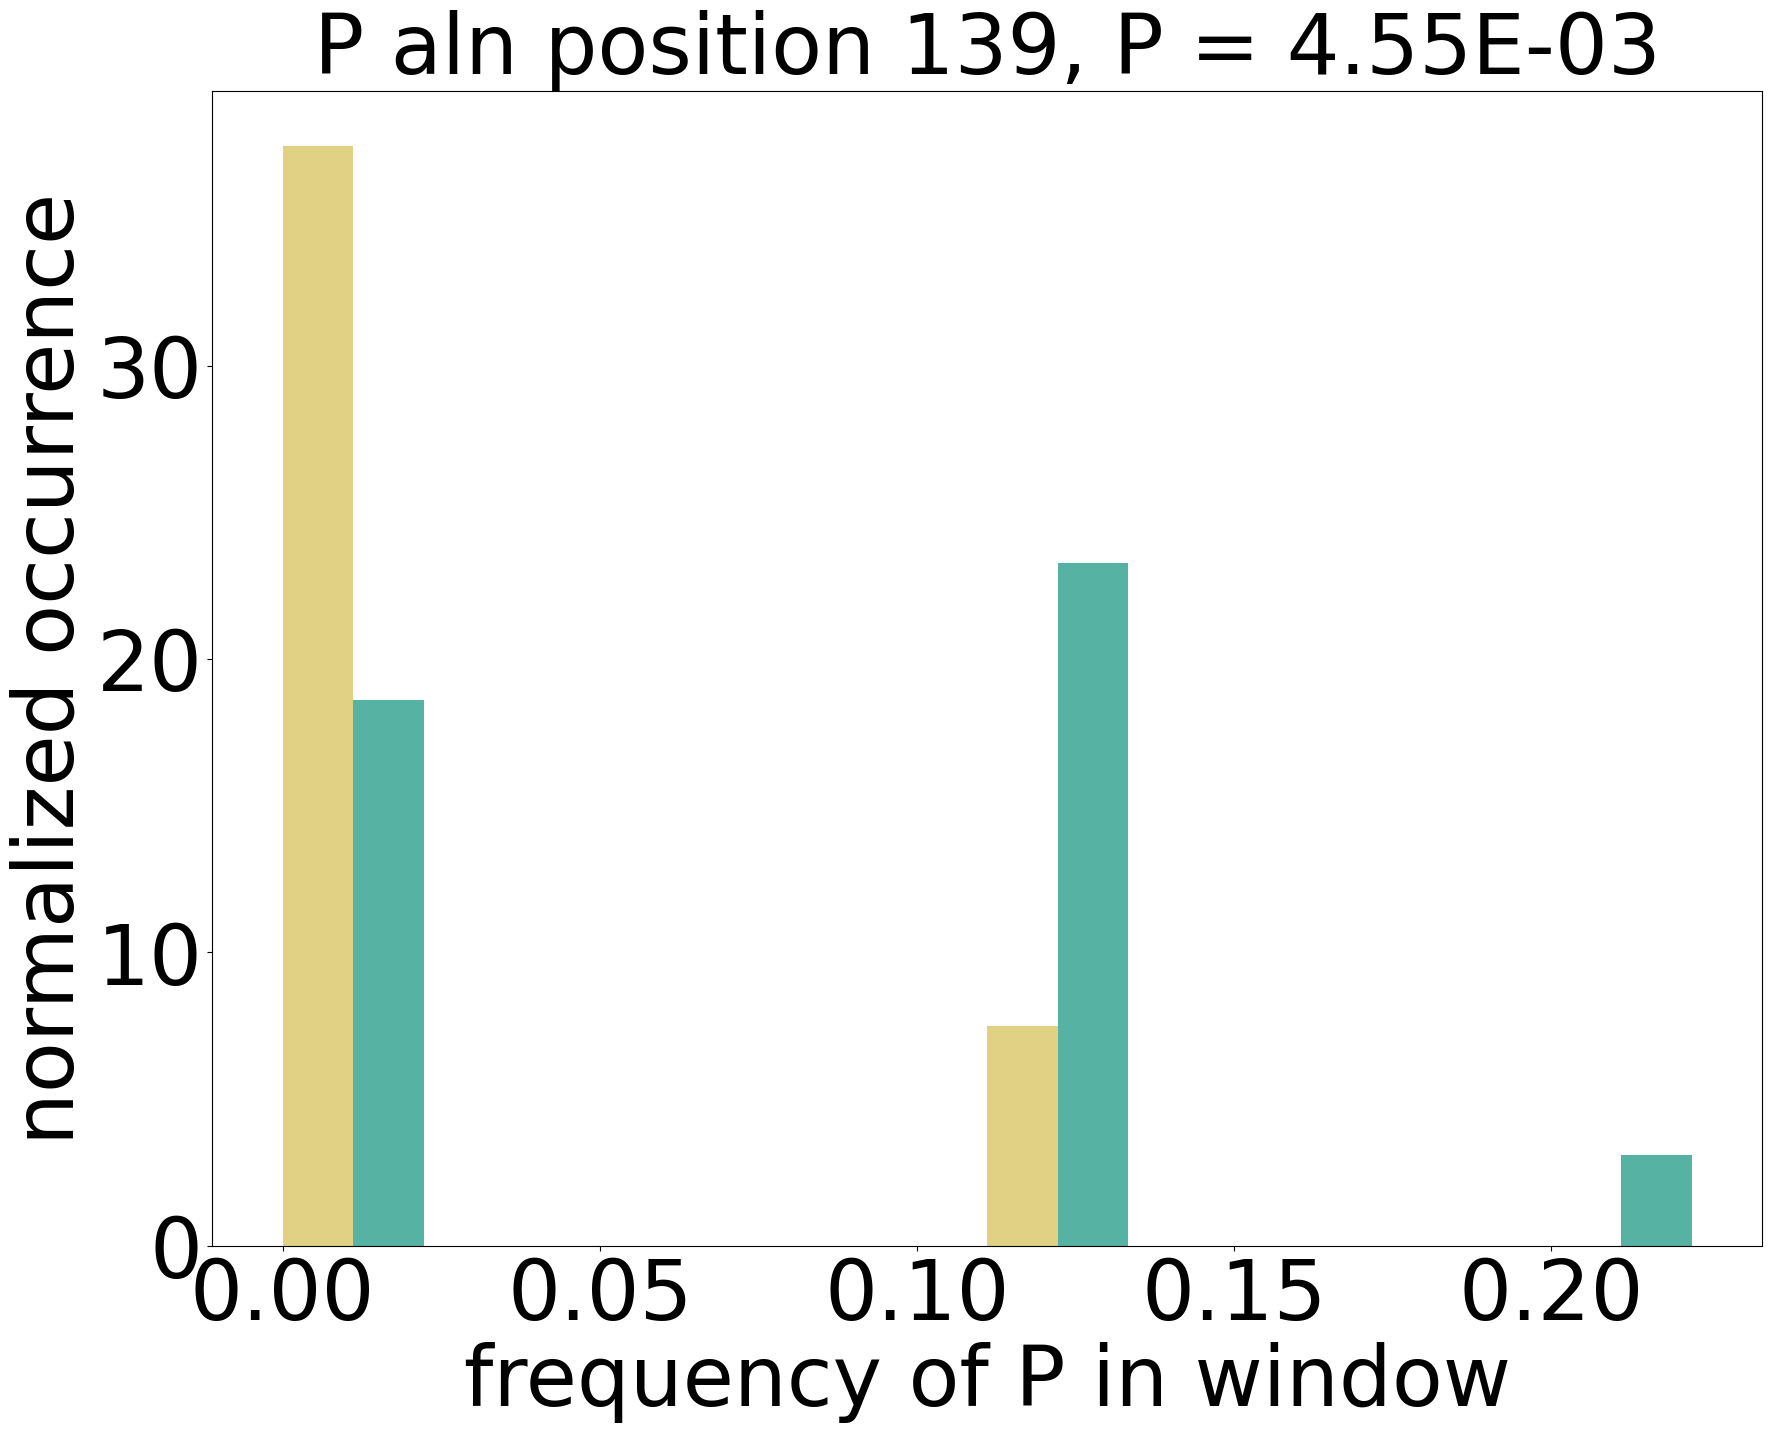

98
292
0.04438058748403577


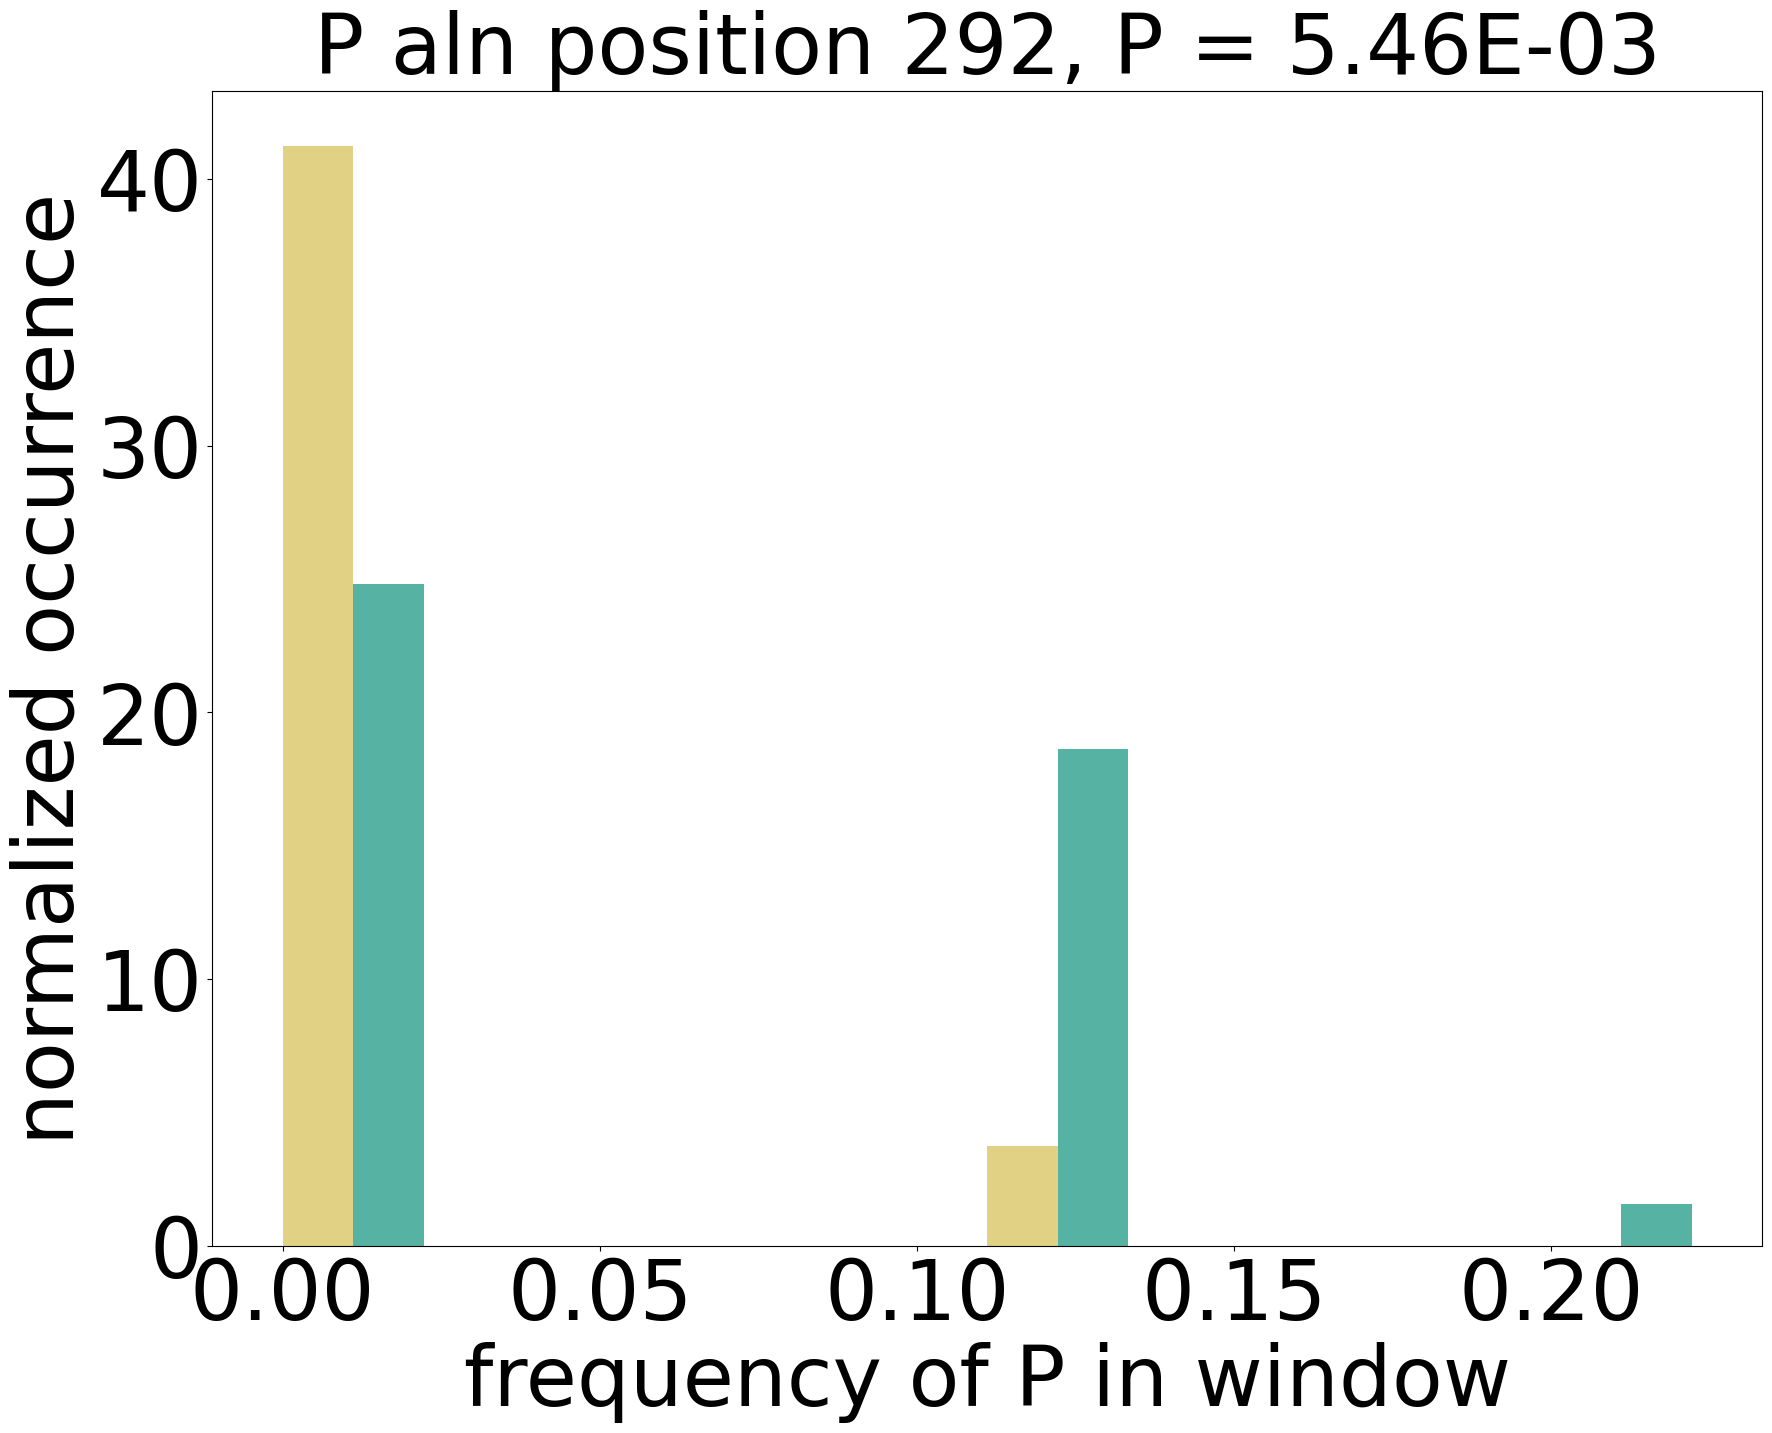

133
397
0.03448275862068966


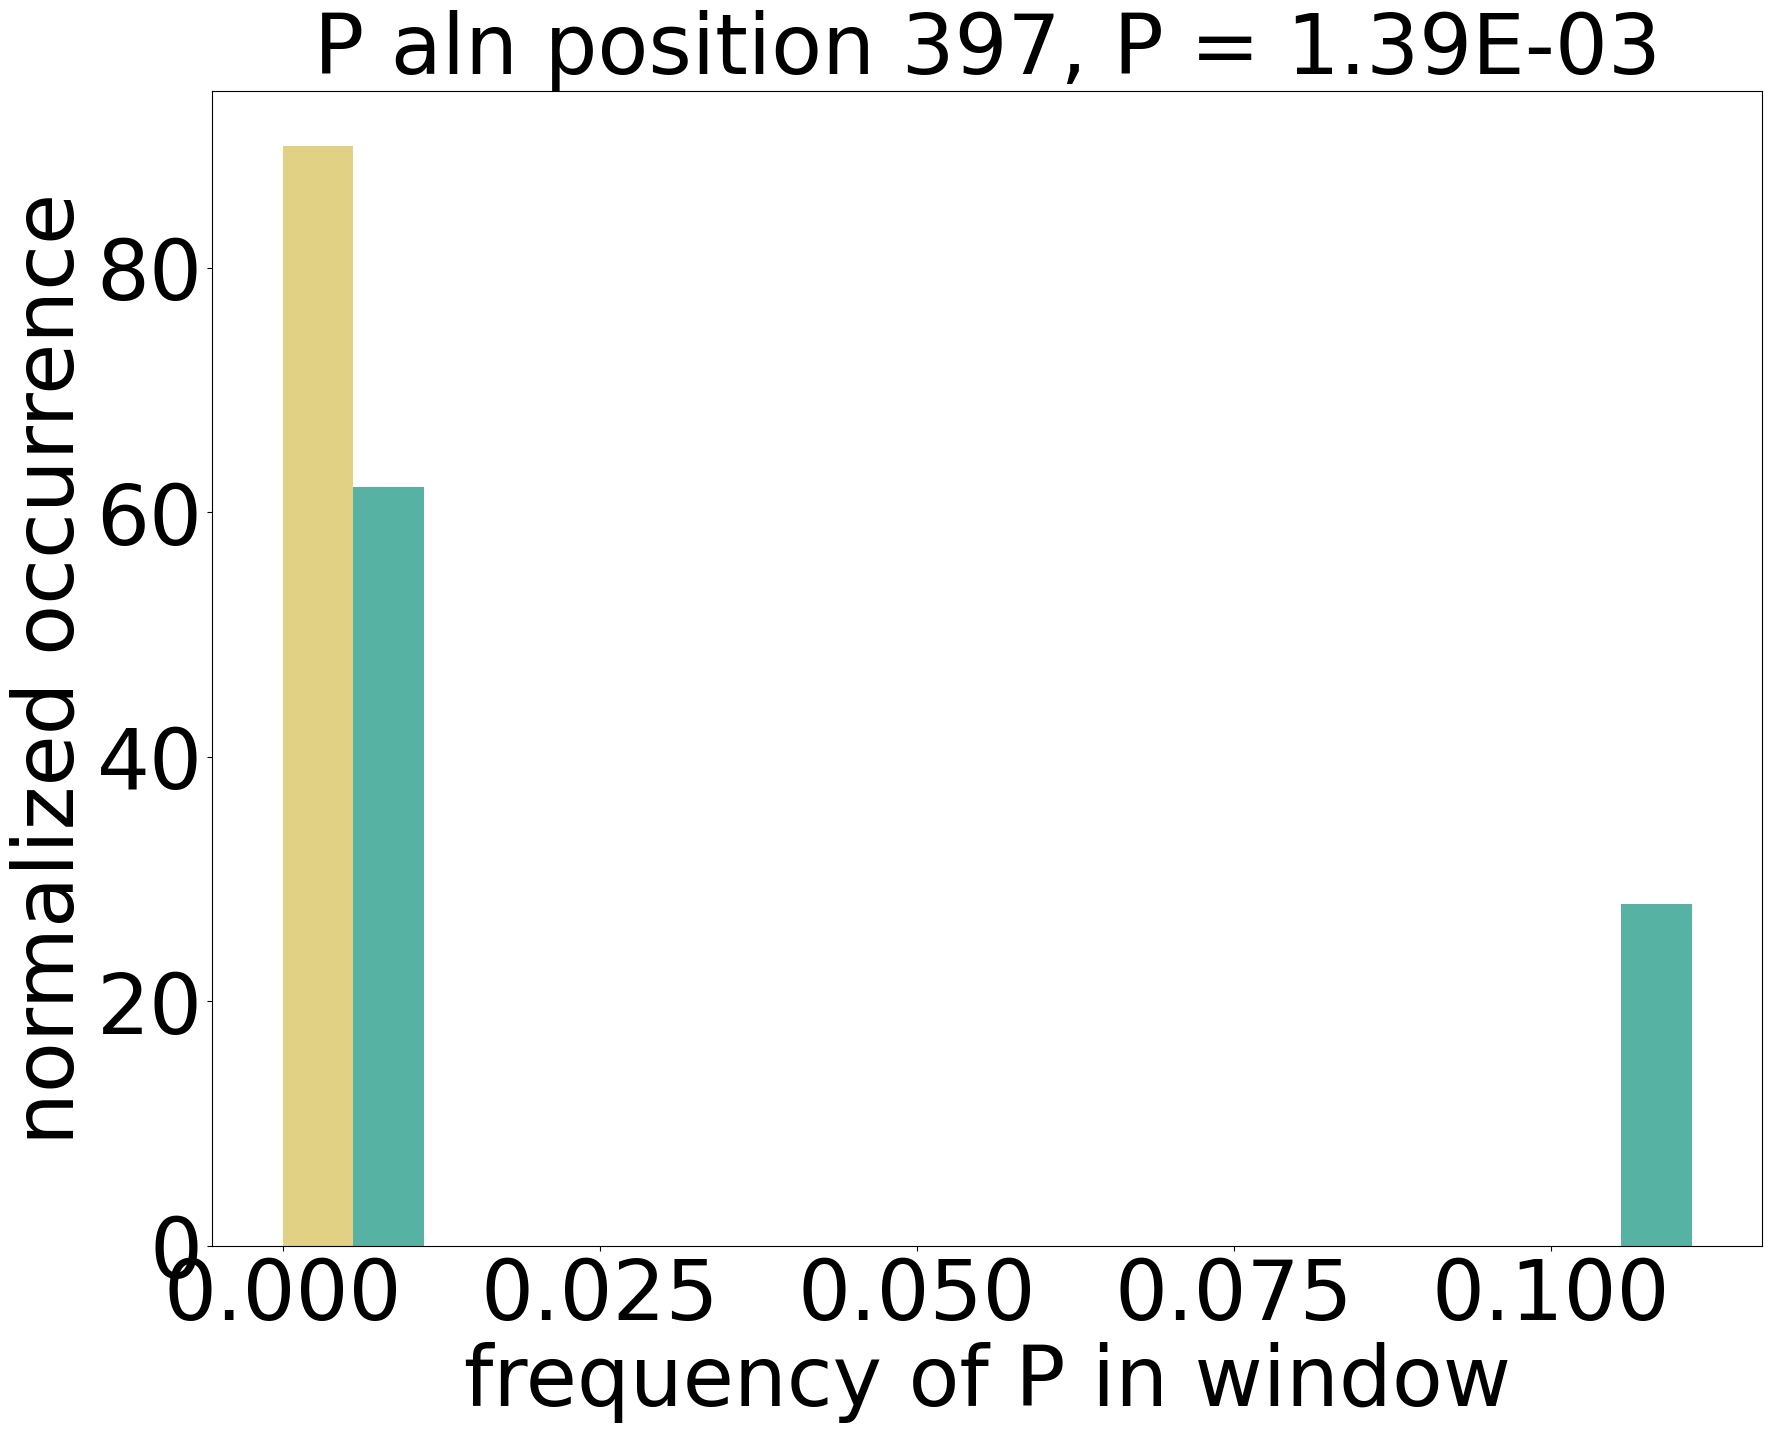

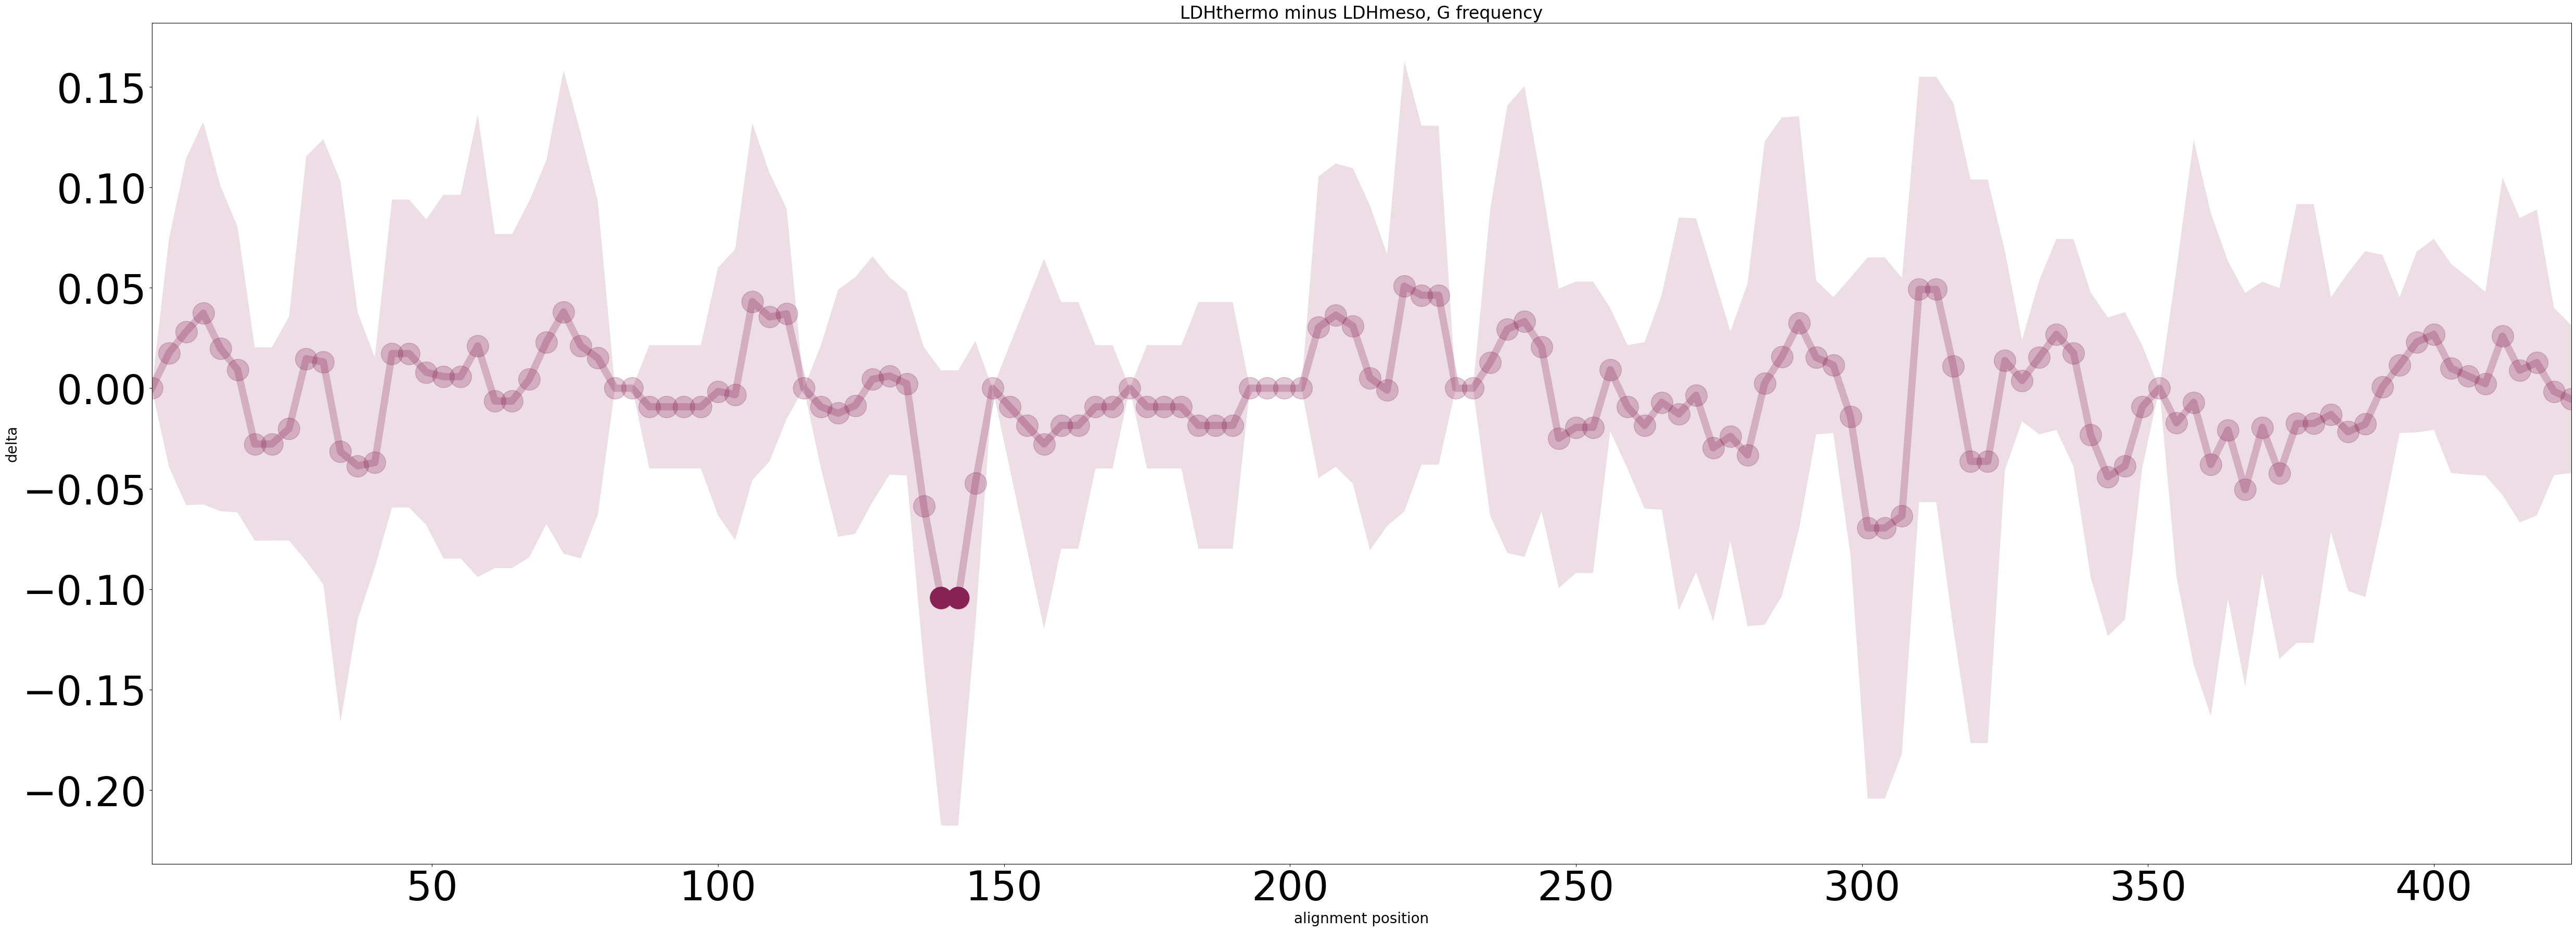

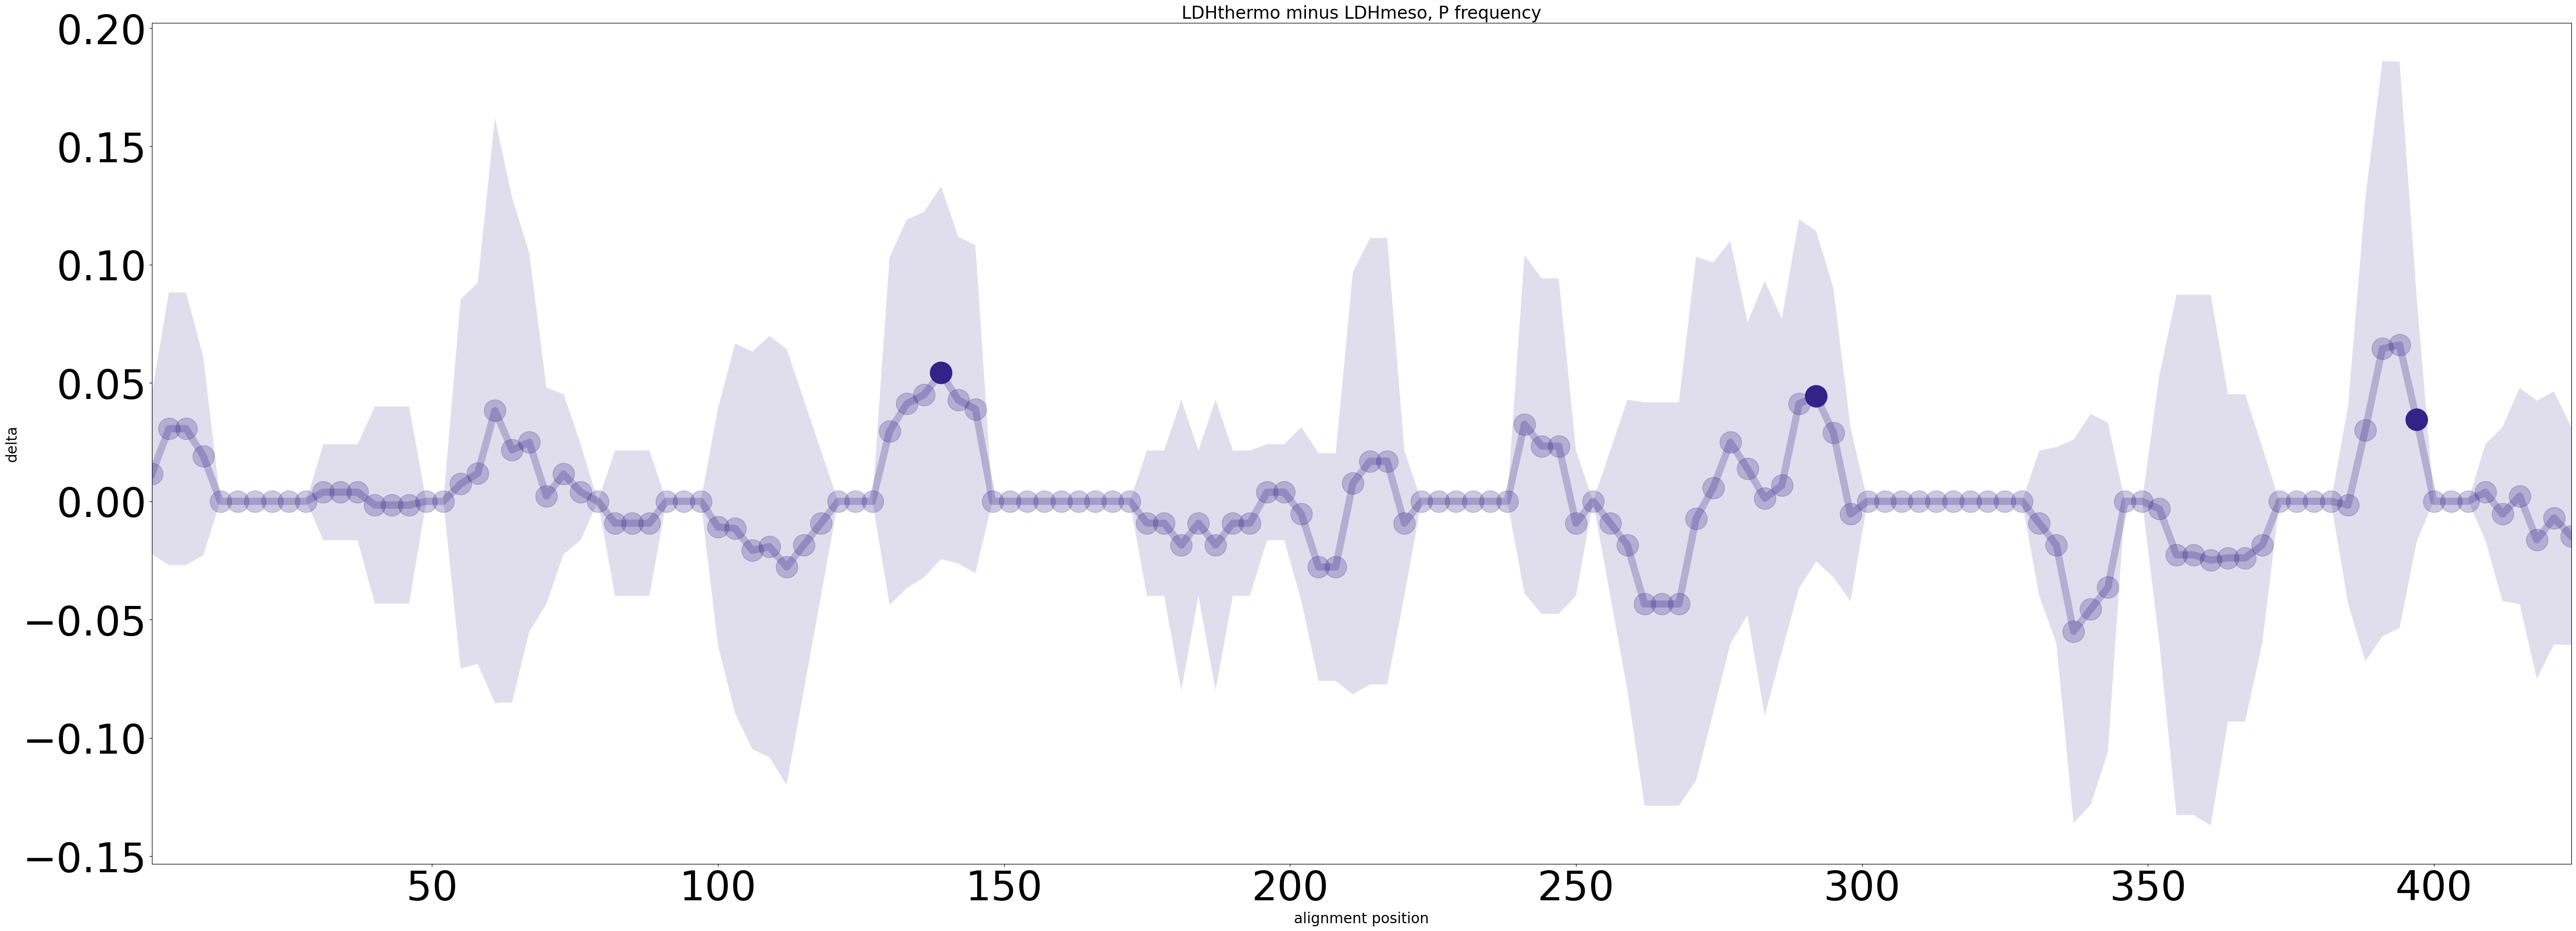

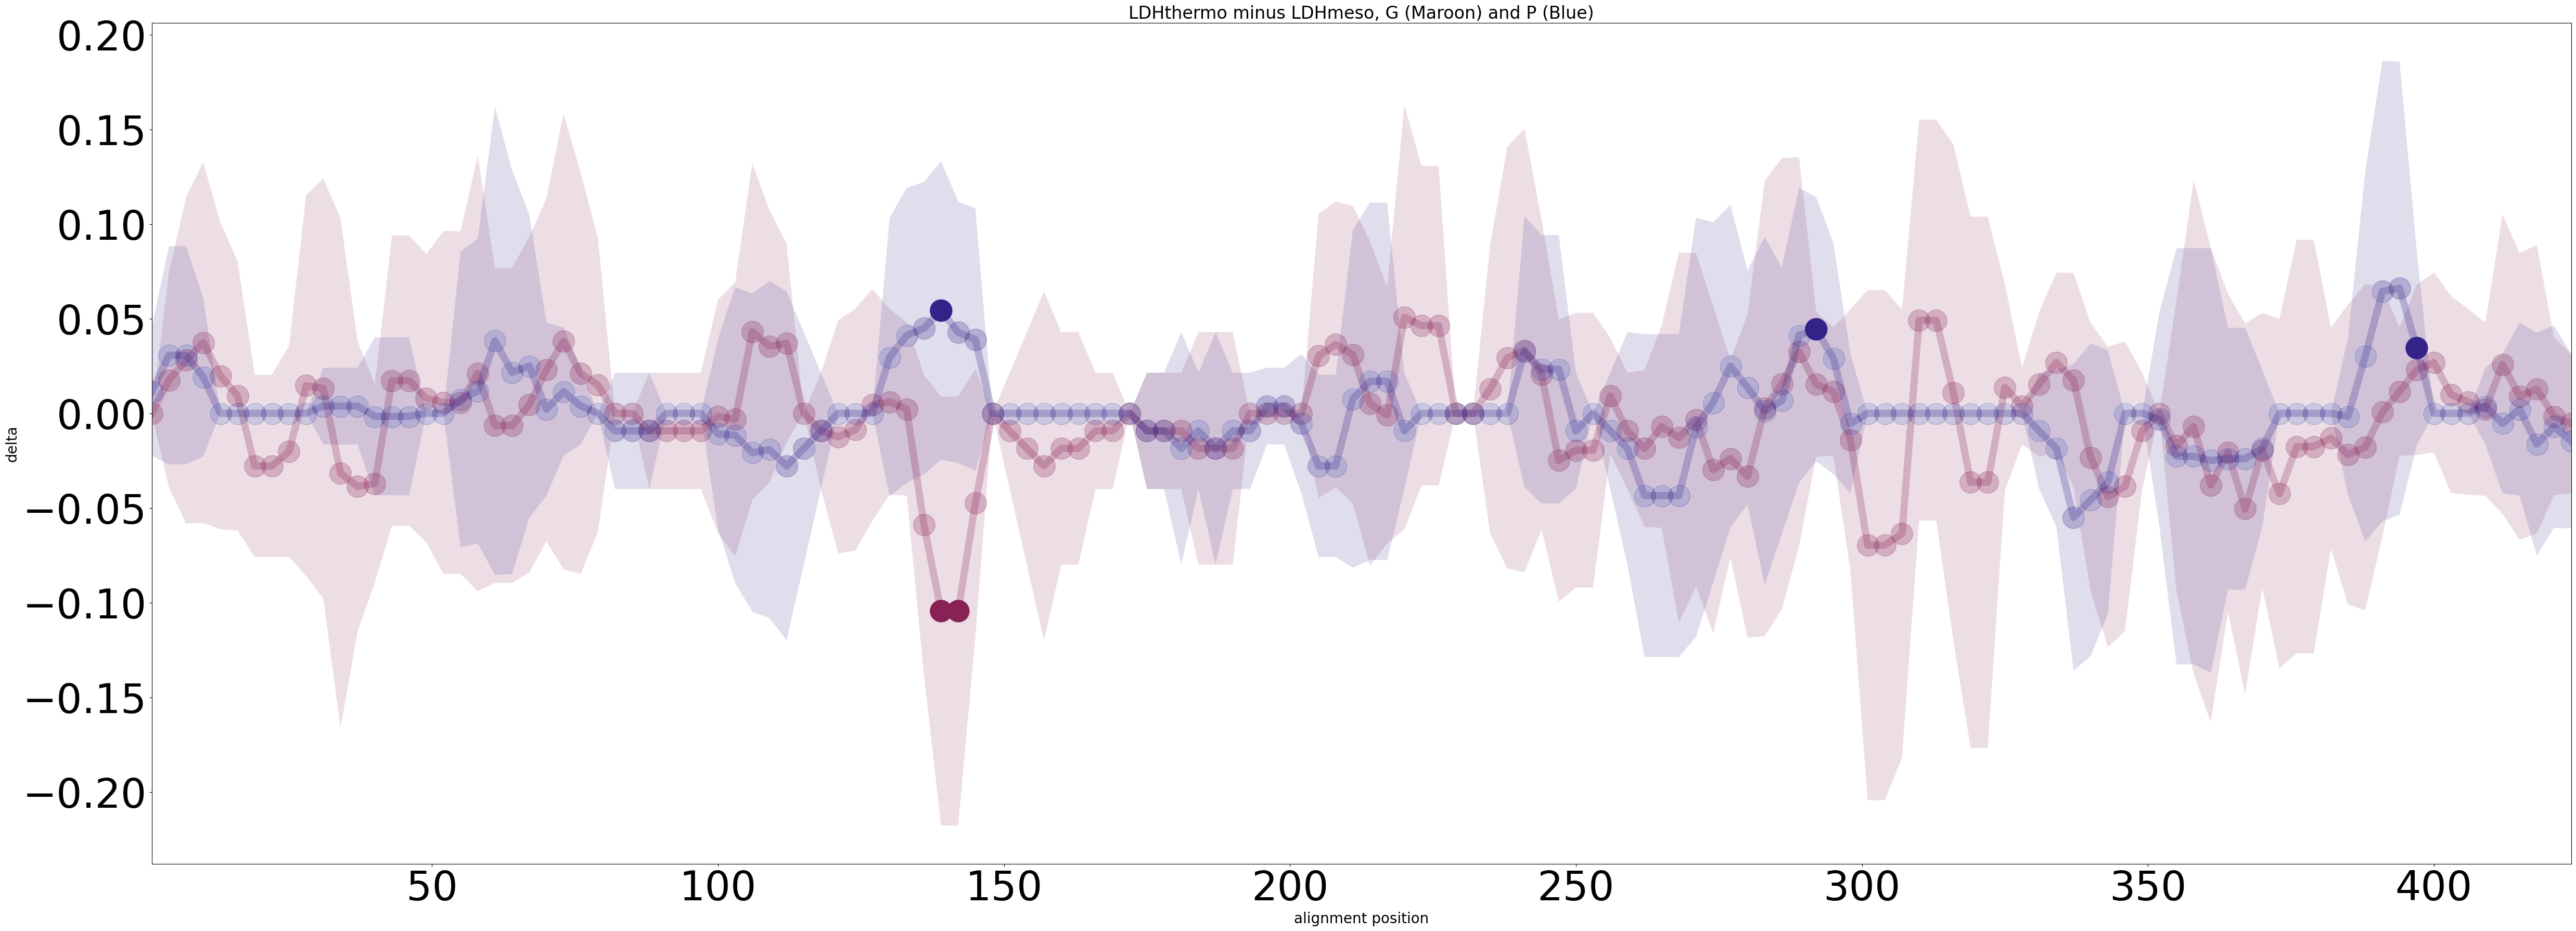

In [2]:
## Allyn J. Schoeffler, PhD
## Loyola University New Orleans

## This code creates visualizations based on SWiCAM frequency data.
## It will plot the difference between average frequencies 
## for a given set of amino acids.
## User input fields are near the top, between hashtag lines

# Package imports; do not edit:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot
import matplotlib.axes
import matplotlib.colors
import warnings

##############################

## User inputs ##
# Input the known subset headers used in the SWiCAM analysis
# The subset headers are the names of your alignment files, as you submitted them to SWiCAM.
# Don't include the file extension (ex: .fa). So, if your alignment file was named "meso.fa", just enter "meso"
# In the delta plots, the convention will be component2 - component1.
component1_header = 'LDHmeso'
component2_header = 'LDHthermo'

# Enter the stride value used for the SWiCAM analysis. 
# Note that you must use the same stride for all frequency files you are submitting here.
# If you did not specify a stride value, then your stride is 1.
stride = 3

# Name the output .csv file where computed data will be saved
# You can give any name you want, but it must have no spaces, and it mucst have a .csv extension.
output_file_name = "ldh_thermo-meso_P-G_9-3.csv"

# Set user-defined cutoffs for significance
# This will only change how the plot points are colored.
# Lower P-values are more significant
# Higher delta values are more significant.
# Note that a Bonferroni correction for the number of windows is automatically applied 
# to the P-value you specify here. 
# Sensible values are P = 0.05 and delta = 0.07 (for a 9-residue window), but every data set is different. 
# The program will output position-specific histograms for any window position that meets both cutoffs. 
uncorrected_P_cutoff = 0.01
delta_cutoff = 0.07

# Read in the individual .csv outputs from SWiCAM
# Two files is the default, but you can add more if desired
freqs_1df = pd.read_csv("Gfreqs.csv")
freqs_2df = pd.read_csv("Pfreqs.csv")

# Below, add the names of the residues under investigation in the input csv files, in input order. 
# The order of amino acids you list here must be the same as the order in which you entered the .csv files above.
aa = ['G', 'P']

# Default color scheme:
# In the delat plots:
# The first amino acid you list will be maroon. The second amino acid will be dark blue.
# In the histograms:
# the first subset you list will be yellow-gold. the second subset will be teal-green.

### You should not edit anything else below this line unless you are an expert user. ###

######################################

freq_df_list = [freqs_1df, freqs_2df]

# Tol Accessible Color Scheme (defaults)
# For more information, see https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40 
##These are the default colors; do not edit
TolMaroon = '#882255'
TolSky = '#88CCEE'
TolRose = '#CC6666'
TolBlue = '#332288'
TolGreen = '#117733'
TolGold = '#DDCC77'
TolTeal = '#44AA99'
TolMagenta = '#AA4499'

# Edit the colors below as desired for the output histograms
# these colors should correspond to your two subsets
user_color1 = TolGold
user_color2 = TolTeal

##These are the defualt color maps; do not edit
# Create colormaps
TolMaroonMap = matplotlib.colors.LinearSegmentedColormap.from_list('TolMaroonMap', ['white', TolMaroon])
TolBlueMap = matplotlib.colors.LinearSegmentedColormap.from_list('TolBlueMap', ['white', TolBlue])
TolGreenMap = matplotlib.colors.LinearSegmentedColormap.from_list('TolGreenMap', ['white', TolGreen])
TolSkyMap = matplotlib.colors.LinearSegmentedColormap.from_list('TolSkyMap', ['white', TolSky])
TolRoseMap = matplotlib.colors.LinearSegmentedColormap.from_list('TolRoseMap', ['white', TolRose])
TolTealMap = matplotlib.colors.LinearSegmentedColormap.from_list('TolTealMap', ['white', TolTeal])
TolGoldMap = matplotlib.colors.LinearSegmentedColormap.from_list('TolGoldMap', ['white', TolGold])
TolMagentaMap = matplotlib.colors.LinearSegmentedColormap.from_list('TolMagentaMap', ['white', TolMagenta])

# If desired, edit the colors below for your output delta plots
# These colors should correspond to the amino acids you are investigating
# Note that typically, the colors and color maps should match
# You may use named colors or hexcodes as well as the default colors defined here. 
# The number of colors you list ***MUST*** match or exceed the number of frequency files you upload

colors = [TolMaroon, TolBlue]
colormaps = [TolMaroonMap, TolBlueMap]

### Do not edit the code below unless you are an expert user ####

# Code below to force python to treat a RuntimeWarning as an exceptable error.
# This will set any dubious P values to zero and cut down on "false positives" (spuriously tiny P-values)
warnings.simplefilter("error", category=Warning, lineno=0, append=False)

# This function creates histograms of all wondow sites for which 
# the delta is greater than the user cutoff 
# and the P-value is less than the user cutoff (with the Bonferroni correction applied)
# It will produce histograms for all available csv files input above under User Inputs
# This function also computes deltas 

def delta_sum_data(freq_df_list, aa, subset1_header, subset2_header, uncorrected_P_cutoff, user_cutoff, color1, color2):
    delta_summary_df = pd.DataFrame()
    aa_counter = 0

    for freqs_df in freq_df_list:
        # break into subsets
        subset1_df = freqs_df.loc[freqs_df['subset'] == subset1_header]
        subset2_df = freqs_df.loc[freqs_df['subset'] == subset2_header]
        
        # drop non-numeric columns
        subset1_df_numeric = subset1_df.drop(columns=['subset', 'header'])
        subset2_df_numeric = subset2_df.drop(columns=['subset', 'header'])

        # list and count the windows and compute the Bonferroni cutoff
        windows = list(subset1_df_numeric)
        bonf_cutoff = uncorrected_P_cutoff/len(windows)
        print(bonf_cutoff)
        print(len(windows))
        
        # instantiate lists of statistics for each window
        avg1s = []
        std1s = []
        SEM1s = []
        avg2s = []
        std2s = []
        SEM2s = []
        Ps = []
        ts = []
        color_code_list = []

        #calculate statistics for each window
        
        for window in windows:
            subset1_i_freqlist = subset1_df_numeric[window]
            subset2_i_freqlist = subset2_df_numeric[window]
            avg1s.append(np.mean(subset1_i_freqlist))
            std1s.append(np.std(subset1_i_freqlist))
            SEM1s.append(scipy.stats.sem(subset1_i_freqlist))
            avg2s.append(np.mean(subset2_i_freqlist))
            std2s.append(np.std(subset2_i_freqlist))
            SEM2s.append(scipy.stats.sem(subset2_i_freqlist))
            
            try:
                T, P = scipy.stats.ttest_ind(subset2_i_freqlist, subset1_i_freqlist, equal_var = False)
                Ps.append(P)
                ts.append(T)
            except RuntimeWarning:
                Ps.append(1)
                ts.append(0)
            if P <= bonf_cutoff:
                color_code_list.append(1)
            else:
                color_code_list.append(0)
            
        
        stats_df = pd.DataFrame()
        stats_df.insert(0, '%s avg' % subset1_header, avg1s)
        stats_df.insert(1, '%s std' % subset1_header, std1s)
        stats_df.insert(2, '%s sem' % subset1_header, SEM1s)
        stats_df.insert(3, '%s avg' % subset2_header, avg2s)
        stats_df.insert(4, '%s std' % subset2_header, std2s)
        stats_df.insert(5, '%s sem' % subset2_header, SEM2s)
        stats_df.insert(6, 'delta %s - %s' % (subset2_header, subset1_header), stats_df['%s avg' % subset2_header] - stats_df['%s avg' % subset1_header])
        stats_df.insert(7, 'P values', Ps)
        stats_df.insert(8, 't values', ts)
        
        stats_df.insert(9, 'neg log P', -1*np.log10(stats_df['P values']))
        stats_df.insert(10, 'color_code', color_code_list)

        #calculate the propogated stdev
        series_of_stdevs = np.sqrt((stats_df['%s std' % subset1_header])**2 + (stats_df['%s std' % subset2_header])**2)
        print(series_of_stdevs)
        
        series_of_deltas = stats_df['delta %s - %s' % (subset2_header, subset1_header)]
        series_of_Ps = stats_df['P values']
        series_of_nlPs = stats_df['neg log P']
        series_of_ts = stats_df['t values']
        series_of_color_codes = stats_df['color_code']

        delta_summary_df.insert(0, '%s delta' % aa[aa_counter], series_of_deltas)
        delta_summary_df.insert(0, '%s P values' % aa[aa_counter], series_of_Ps)
        delta_summary_df.insert(0, '%s neglogP' % aa[aa_counter], series_of_nlPs)
        delta_summary_df.insert(0, '%s t value' % aa[aa_counter], series_of_ts)
        delta_summary_df.insert(0, '%s color code' % aa[aa_counter], series_of_color_codes)
        delta_summary_df.insert(0, 'delta stdev %s' % aa[aa_counter], series_of_stdevs)
                
        # plot histograms if the Bonferroni corrected cutoff is acheived
        # turn dataframe index into alignment position usign the user-input stride
        aln_pos_list = [1]
        for n in range(1, len(list(delta_summary_df.index.values))):
            aln_pos_list.append(aln_pos_list[n-1] + stride)
            
        matplotlib.pyplot.rcParams["figure.figsize"] = (20,15)
        window_psn = 1
        for cutoff in list(delta_summary_df['%s color code' % aa[aa_counter]]):
            if cutoff == 1 and abs(list(delta_summary_df['%s delta' % aa[aa_counter]])[window_psn-1]) >= user_cutoff:
                column_head = str(window_psn)
                matplotlib.pyplot.style.use('./hist.mplstyle')
                print(column_head)
                print(aln_pos_list[window_psn-1])
                print(list(delta_summary_df['%s delta' % aa[aa_counter]])[window_psn-1])
                matplotlib.pyplot.hist([list(subset1_df_numeric[column_head]), list(subset2_df_numeric[column_head])], color = [color1, color2], alpha = 0.9, density = True, rwidth = 10)
                matplotlib.pyplot.title('%s aln position %d, P = %.2E' % (aa[aa_counter], aln_pos_list[window_psn-1], list(delta_summary_df['%s P values' % aa[aa_counter]])[window_psn-1]))
                matplotlib.pyplot.ylabel('normalized occurrence')
                matplotlib.pyplot.xlabel("frequency of %s in window" % aa[aa_counter])
                matplotlib.pyplot.savefig("%s_%s_%s_%d.png" % (subset1_header, subset2_header, aa[aa_counter], aln_pos_list[window_psn-1]))
                matplotlib.pyplot.show()
            window_psn = window_psn + 1
    

        aa_counter = aa_counter + 1
        
    return delta_summary_df

data_summary = delta_sum_data(freq_df_list, aa, component1_header, component2_header, uncorrected_P_cutoff, delta_cutoff, user_color1, user_color2)

#math to turn index into alignment position
aln_pos_list = [1]
for n in range(1, len(list(data_summary.index.values))):
    aln_pos_list.append(aln_pos_list[n-1] + stride)

# The code below uses the data created in the function to create plots of delat values
# for individual csv inputs and for combinations. 

#set figure size & style
matplotlib.pyplot.style.use('./delta.mplstyle')
matplotlib.pyplot.rcParams["figure.figsize"] = (60,21)

##plot individual delta plots
i = 0
for i in range(0, len(aa)):
    #plot points
    matplotlib.pyplot.plot(aln_pos_list, data_summary['%s delta' % aa[i]], alpha = 0.25, color = colors[i], markeredgecolor = colors[i], markerfacecolor = colors[i], marker = "o")
    # color by P-Value cutoff
    matplotlib.pyplot.scatter(aln_pos_list, data_summary['%s delta' % aa[i]], c = data_summary['%s color code' % aa[i]], cmap = colormaps[i])
    matplotlib.pyplot.fill_between(aln_pos_list, data_summary['%s delta' % aa[i]] + data_summary['delta stdev %s' % aa[i]], data_summary['%s delta' % aa[i]] - data_summary['delta stdev %s' % aa[i]], color = colors[i], alpha = 0.15, edgecolor = 'none')
    matplotlib.pyplot.xlim(1, aln_pos_list[-1])
    matplotlib.pyplot.title('%s minus %s, %s frequency' % (component2_header, component1_header, aa[i]))
    matplotlib.pyplot.ylabel('delta')
    matplotlib.pyplot.xlabel("alignment position")
    #matplotlib.pyplot.ylim(-0.2, 0.2)
    matplotlib.pyplot.savefig('%s_delta_%s_%s.png' % (aa[i], component2_header, component1_header))
    matplotlib.pyplot.show()
    i = i +1
    
# Plot the combined delta plots
i = 0
for n in aa:
    #plot points
    matplotlib.pyplot.plot(aln_pos_list, data_summary['%s delta' % n], alpha = 0.25, color = colors[i], markeredgecolor = colors[i], markerfacecolor = colors[i], marker = "o")
    # color by P-Value cutoff
    matplotlib.pyplot.scatter(aln_pos_list, data_summary['%s delta' % n], c = data_summary['%s color code' % n], cmap = colormaps[i])
    matplotlib.pyplot.fill_between(aln_pos_list, data_summary['%s delta' % n] + data_summary['delta stdev %s' % n], data_summary['%s delta' % n] - data_summary['delta stdev %s' % n], color = colors[i], alpha = 0.15, edgecolor = 'none')
    i = i+1
matplotlib.pyplot.title('%s minus %s, %s (Maroon) and %s (Blue)' % (component2_header, component1_header, aa[0], aa[1]))
matplotlib.pyplot.ylabel('delta')
matplotlib.pyplot.xlabel("alignment position")
matplotlib.pyplot.xlim(1, aln_pos_list[-1])
matplotlib.pyplot.savefig('combo_delta_%s_%s.png' % (component2_header, component1_header))
matplotlib.pyplot.show()


# This line of code saves a csv file of the data used to create the delta plots
data_summary.to_csv(output_file_name)
        